<a href="https://colab.research.google.com/github/alam740/Data-Analytics-Course/blob/master/PNN_simple_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discovering a parsimonious neural network - melting temperature laws #

<i>Saaketh Desai</i>, and <i>Alejandro Strachan</i>, School of Materials Engineering, Purdue University <br>

This notebook describes the procedure to train a parsimonious neural network, i.e., a network designed to reproduce the training and testing datasets in the simplest, most interpretable manner possible. We use Keras to train neural networks and the DEAP package for genetic algorithms. The outline of this notebook is:

1. Read datasets and split into training and testing sets
2. Create a generic model
3. Define the objective function for the genetic algorithm
4. Set up the genetic algorithm and save the results

In [ ]:

pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 28.0 MB/s 


In [ ]:
import sys
import os
import random

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K
from keras import initializers
from keras.layers import Dense, Input, Activation, multiply
from keras.models import Sequential, Model, load_model
from keras.layers.merge import add, concatenate

from deap import base, creator, tools, algorithms
from multiprocessing import Pool

## Step 1: Read training and testing data##
We read in a CSV file containing the fundamental quantities such as bulk modulus, shear modulus, density etc., along with the experimental melting temperature. We then compute quantities such as effective sound speed ($v_m$) to compute effective temperatures $\theta_0, \theta_1, \theta_2, \theta_3$ and normalized inputs $\theta_1', \theta_2', \theta_3'$. Finally, we use the `train_test split()` method from scikit-learn to split the data into training and testing sets

In [ ]:
# Melting temperature experiment data
df = pd.read_csv("../data/Combined_data_v3.csv")
print (df.shape)

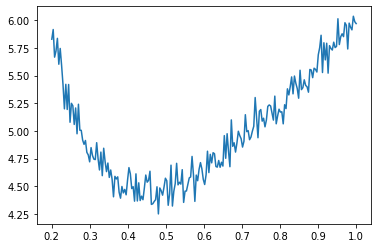

In [ ]:
# 1/X+Z experiment data

sample=218
X=np.linspace(0.2,1,sample)
Y=np.linspace(1,5,sample)
Z= np.linspace(1,5,sample)
O=1/X+Z+0.1*np.random.randn(sample)

plt.plot(X,O)


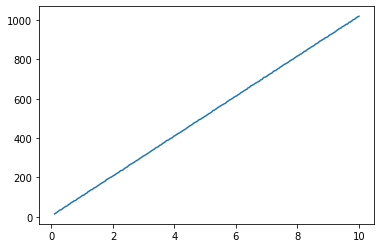

In [ ]:
# X^2+Y experiment data

sample=218
X=np.linspace(0.1,10,sample)
Y=np.linspace(5,20,sample)
Z= np.linspace(1,2,sample)
# Z= np.random.randn(sample)
O=100*X+Y+np.random.randn(sample)
# print(Y.shape)
plt.plot(X,O)


In [ ]:
theta1=X.copy()
theta2=Y.copy()
theta3=Z.copy()

theta1_prime = theta1
theta2_prime = theta2
theta3_prime = theta3

ones = np.ones(len(theta1_prime))

Tm_prime = O.copy()

inputs = np.array([theta1_prime, theta2_prime, theta3_prime, ones], dtype='float')
inputs = inputs.T
outputs = np.array(Tm_prime).reshape(-1, 1)

print (inputs.shape, outputs.shape)

train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size=0.2, random_state=0)
print (train_inputs.shape, train_outputs.shape)
print (test_inputs.shape, test_outputs.shape)

(218, 4) (218, 1)
(174, 4) (174, 1)
(44, 4) (44, 1)


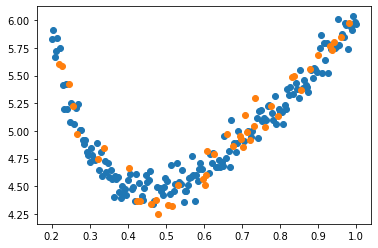

In [ ]:
plt.scatter(train_inputs[:,0],train_outputs)
plt.scatter(test_inputs[:,0],test_outputs)

In [ ]:
act_dict = {0: 'linear', 1: 'squared', 2: 'inverse', 3: 'multiply', 4: 'tanh'}
np.random.seed(300000)
weight_dict = {0: 0, 1: 1, 2: np.random.uniform(-1,1,1)[0]}
nact_terms = 4
nweight_terms = 25 #13

## Step 2: Create a generic model

We will now create a generic model whose activations and weights will be optimized to discover PNNs

In [ ]:
def squared_act(x):
    return x*x

def inverse_act(x):
    return 1/x

In [ ]:
def create_node(input1, input2, input3, name, trainable1, trainable2, trainable3, act, x, idx):
    base = name
    n1 = base + "1"
    n2 = base + "2"
    n3 = base + "3"
    an1 = Dense(1, activation = 'linear', use_bias = False, name=n1, trainable=trainable1) (input1)
    an2 = Dense(1, activation = 'linear', use_bias = False, name=n2, trainable=trainable2) (input2)
    an3 = Dense(1, activation = 'linear', use_bias = False, name=n3, trainable=trainable3) (input3)
    
    node_list = [an1, an2, an3]
    if (act == "multiply"):
        non_zero_list = []
        zero_list = []
        for i, j in enumerate(node_list):
            if (x[idx+i] == 1 or x[idx+i] == 2):
                non_zero_list.append(j)
            else:
                zero_list.append(j)
        if ( len(non_zero_list) == 0 ):
            non_zero_list = node_list
            an = multiply(non_zero_list)
        if ( len(non_zero_list) == 1 ):
            anx = non_zero_list[0]
            an = add([anx, zero_list[0], zero_list[1]])
        else:
            an = multiply(non_zero_list)
    else:
        an = add(node_list)
        if (act == "squared"):
            an = Activation(squared_act) (an)
        elif (act == "inverse"):
            an = Activation(inverse_act) (an)
        else:
            an = Activation(act) (an)
    return an

In [ ]:
def create_model(x):
    #initializer = keras.initializers.RandomUniform(minval=-0.001, maxval=0.001, seed=0)
    bias_initial = keras.initializers.Zeros()

    trainable_list = []
    for i in range(nweight_terms):
        if (x[i+nact_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)

    input1 = Input(shape=(1,))
    input2 = Input(shape=(1,))
    input3 = Input(shape=(1,))
    input4 = Input(shape=(1,))

    a1 = create_node(input1, input2, input3, "a1", trainable_list[0], trainable_list[1], 
                     trainable_list[2], act_dict[x[0]], x, 0+nact_terms)
    a2 = create_node(input1, input2, input3, "a2", trainable_list[3], trainable_list[4], 
                     trainable_list[5], act_dict[x[1]], x, 3+nact_terms)
    a3 = create_node(input1, input2, input3, "a3", trainable_list[6], trainable_list[7], 
                     trainable_list[8], act_dict[x[2]], x, 6+nact_terms)

    an1 = Dense(1, activation = 'linear', use_bias = False, name='output1', trainable=trainable_list[9]) (a1)
    an2 = Dense(1, activation = 'linear', use_bias = False, name='output2', trainable=trainable_list[10]) (a2)
    an3 = Dense(1, activation = 'linear', use_bias = False, name='output3', trainable=trainable_list[11]) (a3)

    an4 = Dense(1, activation = 'linear', use_bias = False, name='output4', trainable=trainable_list[12]) (input4)

    act = act_dict[x[3]]
    node_list = [an1, an2, an3, an4]
    if (act == "multiply"):
        non_zero_list = []
        zero_list = []
        for i, j in enumerate(node_list):
            if (x[9+i] == 1 or x[9+i] == 2):
                non_zero_list.append(j)
            else:
                zero_list.append(j)
        if ( len(non_zero_list) == 0 ):
            non_zero_list = node_list
            an = multiply(non_zero_list)
        elif ( len(non_zero_list) == 1 ):
            anx = non_zero_list[0]
            an = add([anx, zero_list[0], zero_list[1], zero_list[2]])
        else:
            an = multiply(non_zero_list)
    else:
        an = add(node_list)
        if (act == "squared"):
            an = Activation(squared_act) (an)
        elif (act == "inverse"):
            an = Activation(inverse_act) (an)
        else:
            an = Activation(act) (an)
    output = an

    model = Model(inputs=[input1, input2, input3, input4], outputs=[output])
    # optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    optimizer=tf.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    layer_list = []
    for i in range(len(model.layers)):
        name = model.layers[i].name
        if ( ("activation" in name) or ("input" in name) or ("add" in name) or ("multiply" in name) ):
            continue
        else:
            layer_list.append(i)
    
    for i in range(len(layer_list)):
        model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
        #model.layers[layer_list[i]].set_weights( [ np.array( [[ weights_list[i] ]] ) ] )

    #model.summary()

    return model, trainable_list

In [ ]:
losses = []
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + ' Loss: ' + str(logs.get('loss')) + '                     \r')
        losses.append(logs.get('loss'))

def train(model, train_inputs, train_outputs, verbose=False):
    mae_es= keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000,
                                          min_delta=1e-5, verbose=1, mode='auto', restore_best_weights=True)

    terminate = keras.callbacks.TerminateOnNaN()

    EPOCHS = 10000 # Number of EPOCHS
    history = model.fit([train_inputs[:,0], train_inputs[:,1], train_inputs[:,2], train_inputs[:,3]], train_outputs[:,0],
                        epochs=EPOCHS,
                        shuffle=False, batch_size=len(train_inputs), verbose = False, callbacks=[mae_es, terminate],
                        validation_split=0.2)
    
    if verbose:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Sq Error')
        plt.plot(history.epoch, np.array(history.history['loss']),label='Training loss')
        plt.legend()
        plt.show()
    return history

In [ ]:
def f3(w):
    return w

## Step 3: Define the objective function for the genetic algorithm
The objective function consists of three parts: 
1. The mean squared error of the model on the test set 
2. A penalty term for non-linear activation functions
3. A penalty term for weights that are not fixed, simple values such as 0, 1

In [ ]:
def objective_function(individual):
    new_model, trainable = create_model(individual)
    #print ("Trainable: ", trainable)
    valid_flag = True
    stringlist = []
    new_model.summary(print_fn=lambda x: stringlist.append(x))
    for string in stringlist:
        if ("Trainable params" in string):
            ntrainable = int(string[-1])

    if (ntrainable > 0):
        train(new_model, train_inputs, train_outputs, verbose=False)

    mse_train = new_model.evaluate([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3]], 
                                   train_outputs, verbose=0)
    mse_test = new_model.evaluate([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3]], 
                                  test_outputs, verbose=0)

    if (np.isnan(mse_train) or np.isnan(mse_test) or np.isinf(mse_train) or np.isinf(mse_test)):
        valid_flag = False

    weights = new_model.get_weights()
    weight_list = []
    for weight in weights:
        weight_list.append(weight[0][0])
    weight_list = np.array(weight_list)

    #handle nan weights
    if (np.isnan(weight_list).any()):
        valid_flag = False

    if (valid_flag):
        print (weight_list)
    else:
        mse_test = 1e50

    actfunc_term = [i**2 for i in individual[:nact_terms]]
    weights = individual[nact_terms:]
    weight_term = 0
    for j in range(nweight_terms):
        weight_term += f3(weights[j])
        
    mse_test_term = np.log10(mse_test)

    p = 0.1
    obj = mse_test_term + p*(np.sum(actfunc_term) + weight_term)
    print ("Individual: ", individual, flush=True)
    print ("Objective function: ", mse_test, np.sum(actfunc_term), weight_term, obj, flush=True)

    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    # tf.reset_default_graph()
    return (obj,)

## Step 4: Set up the genetic algorithm and saving the results
Each network is expressed as an individual of 17 genes, the genes representing the possible activations and weights. We thus define an individual to be a custom container, which is repeated to create a population. For details on this, please refer to the DEAP guide on setting up a genetic algorithm, which can be found [here](https://deap.readthedocs.io/en/master/)

In [ ]:
################### DEAP #####################
#create fitness class and individual class
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
#pool = Pool(1)
#toolbox.register("attr_int", random.randint, 0, 3)

def custom_initRepeat(container, func, max1, max2, n):
    func_list = []
    for i in range(n):
        if (i < nact_terms):
            func_list.append(func(0, max1))
        else:
            func_list.append(func(0, max2))
    return container(func_list[i] for i in range(n))

#gen = initRepeat(list, random.randint, 3, 7, 4)
toolbox.register("create_individual", custom_initRepeat, creator.Individual, random.randint,
                 max1=4, max2=2, n=nact_terms+nweight_terms)
toolbox.register("population", tools.initRepeat, list, toolbox.create_individual)

def custom_mutation(individual, max1, max2, indpb):
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            if (i < nact_terms):
                individual[i] = random.randint(0, max1)
            else:
                individual[i] = random.randint(0, max2)
    return individual,

We use the two point crossover method for mating two individuals, and perform a random mutation using the custom mutation function. We then define a population size of 200 and define the statistics that we wish to log in the output of the code. The stats object decides which quantities are saved to the logbook

In [ ]:
cxpb = 0.5
mutpb = 0.3
ngens = 3

toolbox.register("mate", tools.cxTwoPoint)
#toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=mutpb)
toolbox.register("mutate", custom_mutation, max1=4, max2=2, indpb=mutpb)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("evaluate", objective_function)

random.seed(100000)
population = toolbox.population(n=5)
interesting_individual = [0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 2]
for i in range(len(interesting_individual)):
    population[0][i] = interesting_individual[i]

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
pop, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngens, stats=stats, halloffame=hof, verbose=True)

Restoring model weights from the end of the best epoch: 6755.
Epoch 7755: early stopping
[0.         0.         0.9779985  1.         0.         0.
 0.         0.         0.         0.9779985  0.9464219  0.
 0.22681406]
Individual:  [0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0]
Objective function:  0.014127352274954319 4 23 0.8500607747200613
Restoring model weights from the end of the best epoch: 3619.
Epoch 4619: early stopping
[0.5233577 1.        0.7499864 0.7499864 2.425422  2.4628694 0.7499864
 0.        0.6581383 0.7499864 0.574984  1.3189121]
Individual:  [3, 0, 3, 4, 0, 1, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 2]
Objective function:  16.478336334228516 34 32 7.816913362862542
